# Intel® oneAPI Hackathon for Open Innovation - Accelerating PyTorch Deep Learning Models on Intel XPUs - Hands-on Lab

## Use of Intel® Extension for PyTorch* for Inference

In this hands-on lab we will demonstrate how **IPEX** can be used for **resnet50** model inference in PyTorch framework. For any other PyTorch model, same process can be followed to leverage IPEX optimizations. 

### Computer Vision Workload - Image Classification with Resnet50 

In this notebook we will be generating sample data to be used for inference with sample computer vision. We will first use stock PyTorch models to generate predictions. 
Then, with minimal code changes using Intel® Extension for PyTorch*, we will see how speedups can be gained over stock PyTorch on Intel® CPU. 

<b> I. Measure baseline Pytorch inference latency for pretrained ResNet50 model</b><br>
<b> II. Apply channel last optimization on the model and input data</b><br>
<b> III. Apply Intel Extension for Pytorch and Torchscript optimization</b><br>
<b> IV. Using IPEX Launch Script - Single instance for inference</b><br>

 Let's start by installing required packages

In [ ]:
#!pip install --user --upgrade torch torchvision tqdm matplotlib# Install Pytorch and Torchvision
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
!python -m pip install intel_extension_for_pytorch
#!pip install --user --upgrade ??? # TO-DO: Modify this line inroder to install Intel Extension for Pytorch

Let's start by importing all the necessary packages and modules

In [1]:
import torch
import torchvision.models as models
import time
from tqdm import tqdm

<b> I. Measure baseline Pytorch inference latency for pretrained ResNet50 model </b><br>
&emsp; The code cells below downloads a ResNet50 model with pretrained weights and runs inference on it using some random input data. The average inference latency per input is saved as <em>pytorch_baseline_latency</em>.

In [2]:
num_images = 1000
num_inference_rounds = 1000
num_warmup_rounds = 5
# Pulling ResNet50 model from Torchvision.models
model = models.resnet50(pretrained=True) 
# Converting the graph to inference mode
model.eval() 

/home/u154865/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/u154865/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
# Utility function for measuring average inference latency
def measure_latency(model, dummy_input):
    global num_warmup_rounds
    global num_inference_rounds
    # A couple of warmup inference rounds to get everything up to speed.
    # Note: The warmup exectuion time is excluded from the comptuation of average inference latency
    for i in range(num_warmup_rounds):
        model(dummy_input[i])
    start_time = time.time()
    for i in tqdm(range(num_inference_rounds)):
        model(dummy_input[i])
    end_time = time.time()
    return 1000*(end_time - start_time)/num_inference_rounds

In [4]:
# Creating an array to hold dummy input images
dummy_input=[]  
for i in range(num_images):
    dummy_input.append(torch.rand(1, 3, 224, 224))

# Measure baseline Pytorch inference latency
pytorch_baseline_latency = measure_latency(model, dummy_input)
print("Pytorch Baseline Inference latency = {:.2f} milliseconds/image".format(pytorch_baseline_latency))

100%|██████████| 1000/1000 [00:35<00:00, 28.08it/s]

Pytorch Baseline Inference latency = 35.63 milliseconds/image


<b> II. Apply channel last optimization on the model and input data</b><br>
&emsp; <em> Hint: More info on channel last layout [here](https://intel.github.io/intel-extension-for-pytorch/latest/tutorials/performance_tuning/tuning_guide.html#channels-last)</em>

In [ ]:
# Apply Channels-Last Memory layout optimization
channel_last_model = model.to(memory_format=torch.channels_last)  # TO-DO Modify thisline to convert the model to Channel-Last memory layout
channel_last_dummy_input=[]  
for i in range(num_images):
    channel_last_dummy_input.append(torch.rand(1, 3, 224, 224).to(memory_format=torch.channels_last)) # TO-DO Modify this line to convert data to Channel-Last memory layout

# Measure performance advantage from Channel-last memory layout optimization
pytorch_channel_last_latency = measure_latency(channel_last_model, channel_last_dummy_input)
print("Pytorch Channel-Last Layout Inference latency = {:.2f} milliseconds/image".format(pytorch_channel_last_latency))

 78%|███████▊  | 777/1000 [00:26<00:07, 29.17it/s]

<b> III. Apply Intel Extension for Pytorch and Torchscript optimization</b><br>
&emsp; Success Criterion : Further optimization using Intel Extension for Pytorch and Torchscript should provide a latency improvement of around 60% compared against the Pytorch Baseline Inference latency<br>
&emsp; <em> Hint: More info on these optimizations [here](https://intel.github.io/intel-extension-for-pytorch/latest/tutorials/examples.html#inference)</em>

In [9]:
# Apply optimizations provided by Intel Extensions For Pytorch
import intel_extension_for_pytorch as ipex   # TO-DO  import Intel Extension for Pytorch
ipex_optimized_model = ipex.optimize(channel_last_model)  # TO-DO invoke the Intel Extension for Pytorch 'optimize' method 

# Apply Torchscript optimization on Intel optimized model
with torch.no_grad():
    d = torch.rand(1, 3, 224, 224)
    jit_model = torch.jit.trace(ipex_optimized_model, d) # TO-DO JIT trace the optimized model
    jit_model = torch.jit.freeze(jit_model) # TO-DO JIT freeze the traced model

# Measure Torchscript + ipex optimized inference latency
jit_optimized_latency = measure_latency(jit_model, channel_last_dummy_input)
print("Intel Extension for Pytorch and Torchscript combined optimized Inference latency = {:.2f} milliseconds/image".format(jit_optimized_latency))

100%|██████████| 1000/1000 [00:12<00:00, 79.90it/s]

Intel Extension for Pytorch and Torchscript combined optimized Inference latency = 12.52 milliseconds/image


<b>Comparing the performance on a bar chart</b><br>

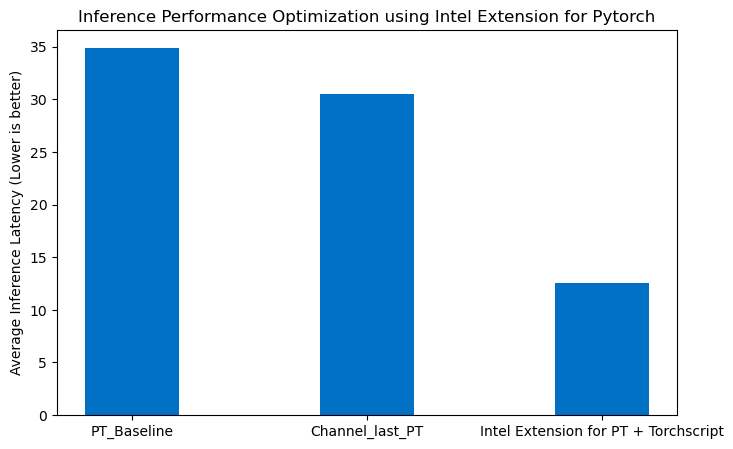

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8, 5))

bar_titles = ['PT_Baseline', 'Channel_last_PT', 'Intel Extension for PT + Torchscript']
bar_values = [pytorch_baseline_latency, pytorch_channel_last_latency, jit_optimized_latency]
plt.bar(bar_titles, bar_values, color ='#0071c5', width = 0.4)
plt.ylabel("Average Inference Latency (Lower is better)")
plt.title("Inference Performance Optimization using Intel Extension for Pytorch")
plt.show()

<b> IV. IPEX Launch Script - Single instance for inference</b><br>

There are several factors that influence performance. Setting configuration options properly contributes to a performance boost. However, there is no unified configuration that is optimal to all topologies. Users need to try different combinations by themselves. A launch script is provided to automate these configuration settings to free users from this complicated work.

In [ ]:
!python -m intel_extension_for_pytorch.cpu.launch --log_path ./logs script.py